<a href="https://colab.research.google.com/github/brook-miller/2023mbai417/blob/main/4-class/customer_lifetime_value_bootstrap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.utils import resample


In [2]:
df = pd.read_csv(r"https://raw.githubusercontent.com/brook-miller/2023mbai417/main/4-class/customer-lifetime-value-auto-insurance.csv")
df.columns = [x.lower().strip().replace(" ", "_") for x in df.columns]
df["customer_lifetime_value"] = df["customer_lifetime_value"].str.replace("$", "", regex=False).str.replace(",", "", regex=False).astype(float)


Text(0.5, 1.0, 'Customer Lifetime Value by State')

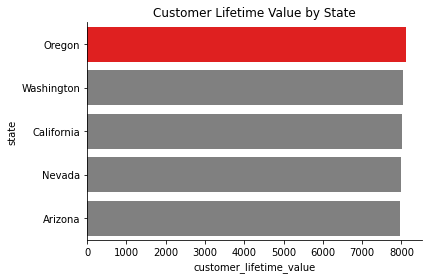

In [3]:
mean_clv = df.groupby(['state']).mean().reset_index()
mean_clv = mean_clv.sort_values(by='customer_lifetime_value', ascending=False)

colors = ['grey'] * 5
colors[0] = 'red'

sns.barplot(data=mean_clv, y="state", x="customer_lifetime_value", palette=colors)
sns.despine( top = True, right = True)
plt.title("Customer Lifetime Value by State")

### Oregon's Customer Lifetime Value is not Statistically Different from the Average of Other States


Text(0.5, 1.0, 'Oregon Histogram')

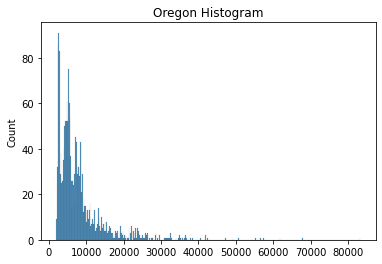

In [4]:
oregon_values = df.loc[df["state"] == "Oregon"]["customer_lifetime_value"].to_list()
sns.histplot(data=oregon_values, binwidth=200)
plt.title("Oregon Histogram")

Text(0.5, 1.0, 'Oregon Histogram')

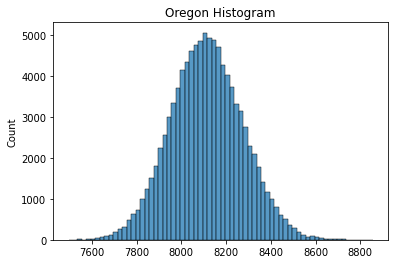

In [5]:
oregon_bootstrap_means = []
n_iterations = 100000
for i in range(n_iterations):
    sample = resample(oregon_values, replace=True, n_samples = len(oregon_values))
    oregon_bootstrap_means.append(np.mean(sample))

sns.histplot(data=oregon_bootstrap_means, binwidth=20)
plt.title("Oregon Histogram")

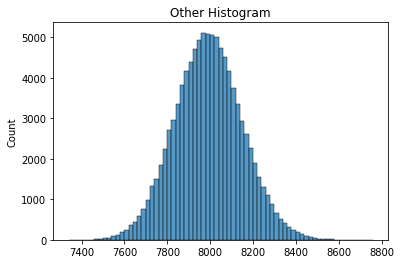

In [6]:
other_values = df.loc[df["state"] != "Oregon"]["customer_lifetime_value"].to_list()
other_bootstrap_means = []
n_iterations = 100000
for i in range(n_iterations):
    sample = resample(other_values, replace=True, n_samples=len(oregon_values))
    other_bootstrap_means.append(np.mean(sample))

sns.histplot(data=other_bootstrap_means, binwidth=20)
plt.title("Other Histogram");

In [7]:
mean_df = pd.DataFrame(other_bootstrap_means)
mean_df.columns = ["other_states"]

mean_df["oregon"] = oregon_bootstrap_means

mean_df = pd.melt(mean_df, value_vars=["other_states", "oregon"] )

In [8]:
mean_df

,variable,value
0,other_states,8084.995356
1,other_states,8024.338493
2,other_states,8195.397833
3,other_states,7893.795150
4,other_states,7973.200206
...,...,...
199995,oregon,7938.539732
199996,oregon,8289.689886
199997,oregon,7946.274510
199998,oregon,8200.604747


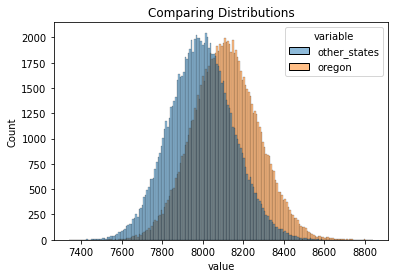

In [9]:
sns.histplot(x='value', data=mean_df, hue='variable', common_norm=False);
plt.title("Comparing Distributions");

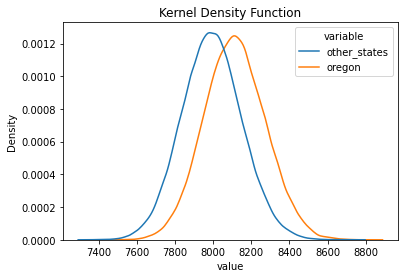

In [10]:
#another way to show the distribution the KDE will be smoother (imagine if we were restricted in the number bootstrap samples so our histogram was bumpier)
sns.kdeplot(x='value', data=mean_df, hue='variable')
plt.title("Kernel Density Function");

In [11]:
from scipy.stats import ttest_ind
from scipy.stats import shapiro

# I added this as I was curious about the distribution of the data is normal enough for a t-test (it is not)
stat, p_value = shapiro(oregon_values)
print(f"oregon shapiro: statistic={stat:.4f}, p-value={p_value:.4f}")

stat, p_value = shapiro(other_values)
print(f"other shapiro: statistic={stat:.4f}, p-value={p_value:.4f}")

# we really shouldn't use t test as the data isn't normal

stat, p_value = ttest_ind(oregon_values, other_values)
print(f"t-test: statistic={stat:.4f}, p-value={p_value:.4f}")

oregon shapiro: statistic=0.6871, p-value=0.0000
other shapiro: statistic=0.6931, p-value=0.0000
t-test: statistic=0.6368, p-value=0.5243


In [12]:
from scipy.stats import kstest

# KS test is fairly widely used
# https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test

stat, p_value = kstest(oregon_values, other_values)
print(f"Kolmogorov-Smirnov Test: statistic={stat:.4f}, p-value={p_value:.4f}")

Kolmogorov-Smirnov Test: statistic=0.0239, p-value=0.4007


Alternatively: https://en.wikipedia.org/wiki/Bootstrapping_(statistics)#Bootstrap_hypothesis_testing (I don't think this is currently implemented in sklearn or scipy)


### making the small multiples graph (to see the bars you need to open it in colab)

In [13]:
vehicle_class_df = df.groupby(["vehicle_class", "state"]).count().reset_index()[["vehicle_class", "state", "customer"]].rename(columns={"customer":"count"})
vehicle_class_df = vehicle_class_df.pivot(index = "state", columns=["vehicle_class"])["count"].rename_axis(columns=None).reset_index()
cols = vehicle_class_df.columns[1:7].to_list()
vehicle_class_df[cols] = vehicle_class_df[cols].div(vehicle_class_df[cols].sum(axis=1), axis=0)
vehicle_class_df.style.bar(subset=cols, color='#aaaaaa',align= 'mid', vmin=0, vmax=.6, width=60)

,state,Four-Door Car,Luxury Car,Luxury SUV,SUV,Sports Car,Two-Door Car
0,Arizona,0.522042,0.017015,0.019335,0.183295,0.055684,0.202630
1,California,0.507833,0.016536,0.023934,0.194952,0.056571,0.200174
2,Nevada,0.484663,0.013804,0.019939,0.197853,0.064417,0.219325
3,Oregon,0.492776,0.015480,0.022188,0.204850,0.047988,0.216718
4,Washington,0.527183,0.028007,0.016474,0.194399,0.029654,0.204283


From here, I'd probably use excel or just hand it off to a designer to make it look better.